<a href="https://colab.research.google.com/github/Soumayas/Calcul_des_incertitudes_de_mesure_en_utilisant_ML/blob/main/Test_CLE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




## **Sujet :**

en pièce jointe des fichiers de données d’un même participant pour trois conditions de test avec différents niveaux de difficulté cognitive (rest<1back<2back). Le défi consiste à fournir deux graphiques, un pour le ratio HF/LF du HRV et l’autre pour le RMSSD, qui auront chacun 3 courbes - une pour chaque condition. Utilise la librairie Neurokit pour extraire ces caractéristiques du signal ECG Pour obtenir quelques points à tracer par participant-condition, fait le calcul du ratio HF/LF et RMSSD sur des fenêtres de 40 à 60 secondes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chemins des fichiers

In [ ]:
file_path1 = '/content/drive/MyDrive/Test/Polar_CL1.csv'
file_path2 = '/content/drive/MyDrive/Test/Polar_CL2.csv'
file_path3 = '/content/drive/MyDrive/Test/Polar_Rest.csv'

In [ ]:
%cd /content/

/content


In [ ]:
%ls

drive/  sample_data/


In [ ]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 12.9 MB/s eta 0:00:00


# Importation des bibliothèques

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import os
from scipy.signal import find_peaks

#Détection des pics R et filtrage du signal ECG
 Dans cette section, je traite le signal ECG pour identifier les pics R des complexes QRS puis,on applique un filtrage passe-bande pour éliminer le bruit et améliorer la détection des pics R.

Les principales étape du traitement sont :

-Prétraitement des données : Chargement et normalisation du temps.

-Filtrage passe-bande : Élimination du bruit

-Détection des pics R : Utilisation de find_peaks pour repérer **les maxima** correspondant aux pics R.

-Regroupement des pics voisins : Élimination des doublons pour ne conserver que le pic R dominant dans chaque groupe.

-Visualisation des résultats : Affichage du signal ECG avec les pics R détectés.

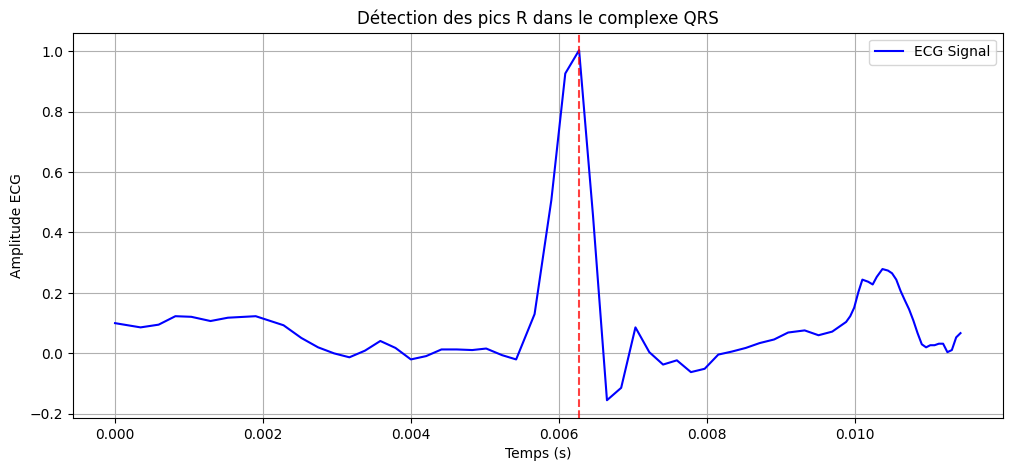

In [ ]:

# (1647455022902057503 - 1647454741508970206) / 10^9

def detect_r_peaks(file_path, tolerance=0.2, threshold_ratio=0.04, time_limit=0.5):
    # Charger et prétraiter les données
    df_full = pd.read_csv(file_path)
    df_full["time_sec"] = df_full["secs"] + df_full["nsecs"] / 1e9
    df_full["time_sec"] -= df_full["time_sec"].iloc[0]  # Décaler l'origine du temps

    # Filtrer pour afficher les données jusqu'à time_limit secondes
    df_5s = df_full[df_full["time_sec"] <= time_limit]

    # Détection des pics R sur le signal ECG
    peaks, _ = find_peaks(df_5s["value"], height=np.max(df_5s["value"]) * threshold_ratio)

    # Regrouper les pics proches
    grouped_peaks = group_close_peaks(peaks, df_5s["time_sec"], tolerance)

    # Conserver le pic maximal de chaque groupe
    final_peaks = [max(group, key=lambda x: df_5s["value"].iloc[x]) for group in grouped_peaks]

    # Tracer le signal ECG avec les pics R détectés
    plot_ecg_with_r_peaks(df_5s, final_peaks)

def group_close_peaks(peaks, time_sec, tolerance):
    grouped_peaks = []
    for peak in peaks:
        added = False
        for group in grouped_peaks:
            # Regrouper les pics proches en fonction de la tolérance
            if abs(time_sec.iloc[peak] - time_sec.iloc[group[-1]]) < tolerance:
                group.append(peak)
                added = True
                break
        if not added:
            grouped_peaks.append([peak])
    return grouped_peaks

def plot_ecg_with_r_peaks(df_5s, final_peaks):
    plt.figure(figsize=(12, 5))
    plt.plot(df_5s["time_sec"], df_5s["value"], label="ECG Signal", color="b")

    # Ajouter des lignes verticales aux pics R
    for peak in final_peaks:
        plt.axvline(x=df_5s["time_sec"].iloc[peak], color='r', linestyle='--', alpha=0.75)

    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude ECG")
    plt.title("Détection des pics R dans le complexe QRS")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel de la fonction
detect_r_peaks(file_path1)

In [ ]:
from scipy.signal import find_peaks, butter, filtfilt

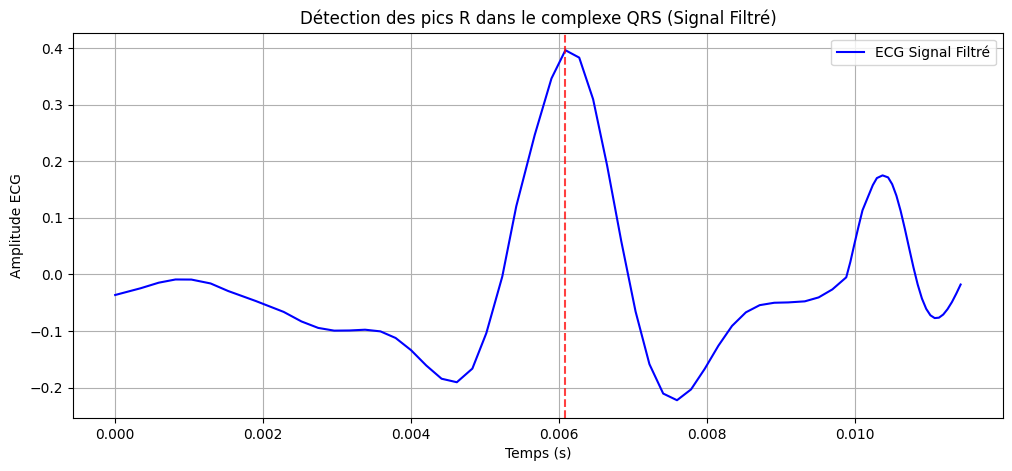

In [ ]:

# Fonction pour appliquer un filtre passe-bande
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Fonction pour filtrer le signal ECG
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

def detect_r_peaks(file_path, tolerance=0.1, threshold_ratio=0.4, time_limit=0.5, lowcut=0.5, highcut=95, fs=1000):
    # Charger et prétraiter les données
    df_full = pd.read_csv(file_path)
    df_full["time_sec"] = df_full["secs"] + df_full["nsecs"] / 1e9
    df_full["time_sec"] -= df_full["time_sec"].iloc[0]  # Décaler l'origine du temps

    # Filtrer pour afficher les données jusqu'à time_limit secondes
    df_5s = df_full[df_full["time_sec"] <= time_limit]

    # Appliquer un filtrage passe-bande pour nettoyer le signal ECG
    ecg_signal_filtered = bandpass_filter(df_5s["value"], lowcut, highcut, fs)

    # Détection des pics R sur le signal ECG filtré
    peaks, _ = find_peaks(ecg_signal_filtered, height=np.max(ecg_signal_filtered) * threshold_ratio)

    # Regrouper les pics proches
    grouped_peaks = group_close_peaks(peaks, df_5s["time_sec"], tolerance)

    # Conserver le pic maximal de chaque groupe
    final_peaks = [max(group, key=lambda x: df_5s["value"].iloc[x]) for group in grouped_peaks]

    # Tracer le signal ECG avec les pics R détectés
    plot_ecg_with_r_peaks(df_5s, final_peaks, ecg_signal_filtered)

def group_close_peaks(peaks, time_sec, tolerance):
    grouped_peaks = []
    for peak in peaks:
        added = False
        for group in grouped_peaks:
            # Regrouper les pics proches en fonction de la tolérance
            if abs(time_sec.iloc[peak] - time_sec.iloc[group[-1]]) < tolerance:
                group.append(peak)
                added = True
                break
        if not added:
            grouped_peaks.append([peak])
    return grouped_peaks

def plot_ecg_with_r_peaks(df_5s, final_peaks, ecg_signal_filtered):
    plt.figure(figsize=(12, 5))
    plt.plot(df_5s["time_sec"], ecg_signal_filtered, label="ECG Signal Filtré", color="b")

    # Ajouter des lignes verticales aux pics R
    for peak in final_peaks:
        plt.axvline(x=df_5s["time_sec"].iloc[peak], color='r', linestyle='--', alpha=0.75)

    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude ECG")
    plt.title("Détection des pics R dans le complexe QRS (Signal Filtré)")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel de la fonction
detect_r_peaks(file_path1)

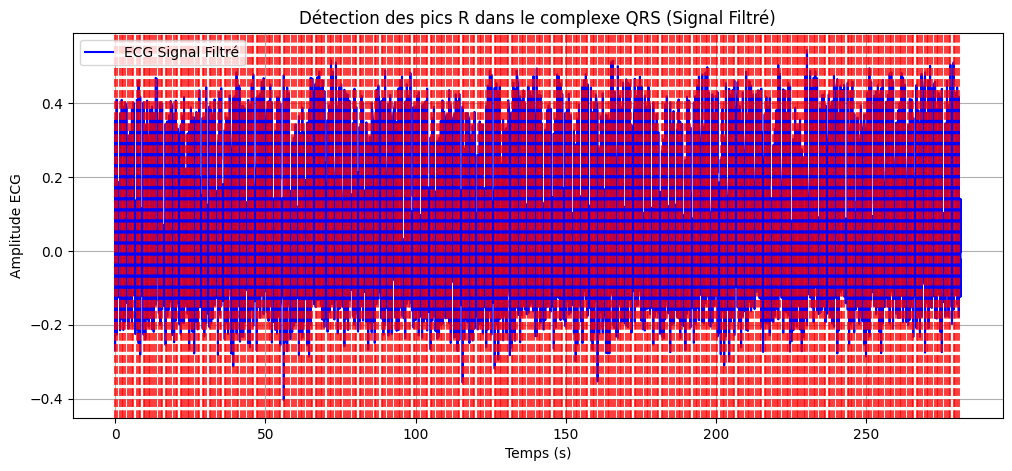

In [ ]:

# Fonction pour appliquer un filtre passe-bande
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Fonction pour filtrer le signal ECG
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

def detect_r_peaks(file_path, tolerance=0.1, threshold_ratio=0.4, time_limit=282, lowcut=0.5, highcut=95, fs=1000):
    # Charger et prétraiter les données
    df_full = pd.read_csv(file_path)
    df_full["time_sec"] = df_full["secs"] + df_full["nsecs"] / 1e9
    df_full["time_sec"] -= df_full["time_sec"].iloc[0]  # Décaler l'origine du temps

    # Filtrer pour afficher les données jusqu'à time_limit secondes
    df_5s = df_full[df_full["time_sec"] <= time_limit]

    # Appliquer un filtrage passe-bande pour nettoyer le signal ECG
    ecg_signal_filtered = bandpass_filter(df_5s["value"], lowcut, highcut, fs)

    # Détection des pics R sur le signal ECG filtré
    peaks, _ = find_peaks(ecg_signal_filtered, height=np.max(ecg_signal_filtered) * threshold_ratio)

    # Regrouper les pics proches
    grouped_peaks = group_close_peaks(peaks, df_5s["time_sec"], tolerance)

    # Conserver le pic maximal de chaque groupe
    final_peaks = [max(group, key=lambda x: df_5s["value"].iloc[x]) for group in grouped_peaks]

    # Tracer le signal ECG avec les pics R détectés
    plot_ecg_with_r_peaks(df_5s, final_peaks, ecg_signal_filtered)

def group_close_peaks(peaks, time_sec, tolerance):
    grouped_peaks = []
    for peak in peaks:
        added = False
        for group in grouped_peaks:
            # Regrouper les pics proches en fonction de la tolérance
            if abs(time_sec.iloc[peak] - time_sec.iloc[group[-1]]) < tolerance:
                group.append(peak)
                added = True
                break
        if not added:
            grouped_peaks.append([peak])
    return grouped_peaks

def plot_ecg_with_r_peaks(df_5s, final_peaks, ecg_signal_filtered):
    plt.figure(figsize=(12, 5))
    plt.plot(df_5s["time_sec"], ecg_signal_filtered, label="ECG Signal Filtré", color="b")

    # Ajouter des lignes verticales aux pics R
    for peak in final_peaks:
        plt.axvline(x=df_5s["time_sec"].iloc[peak], color='r', linestyle='--', alpha=0.75)

    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude ECG")
    plt.title("Détection des pics R dans le complexe QRS (Signal Filtré)")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel de la fonction
detect_r_peaks(file_path1)

# Analyse du RMSSD pour Différentes Conditions Cognitives







Dans cette section, j'analyse la variabilité du rythme cardiaque (HRV) à travers le paramètre RMSSD pour trois conditions de test.

Le signal ECG est d'abord filtré à l'aide d'un filtre passe-bande afin d'éliminer les interférences et les bruits indésirables. Ensuite, les pics R sont détectés, et regroupés afin d'extraire les intervalles RR. à partir de ces intervalles, je calcule la valeur RMSSD sur des fenêtres glissantes de 40 à 60 secondes, ce qui permet d'observer l'évolution du RMSSD au fil du temps pour chaque condition.

Enfin, le traçage des courbes du RMSSD pour chaque condition afin de visualiser l'effet de la charge cognitive sur la variabilité du rythme cardiaque.

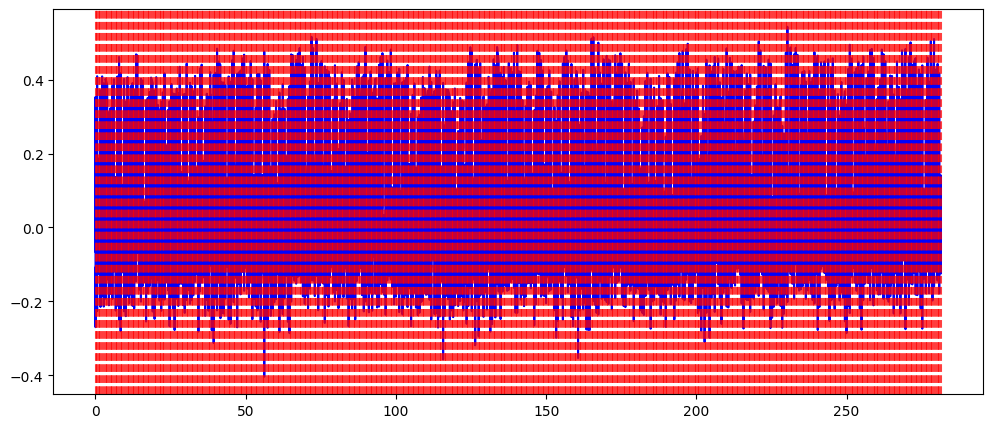

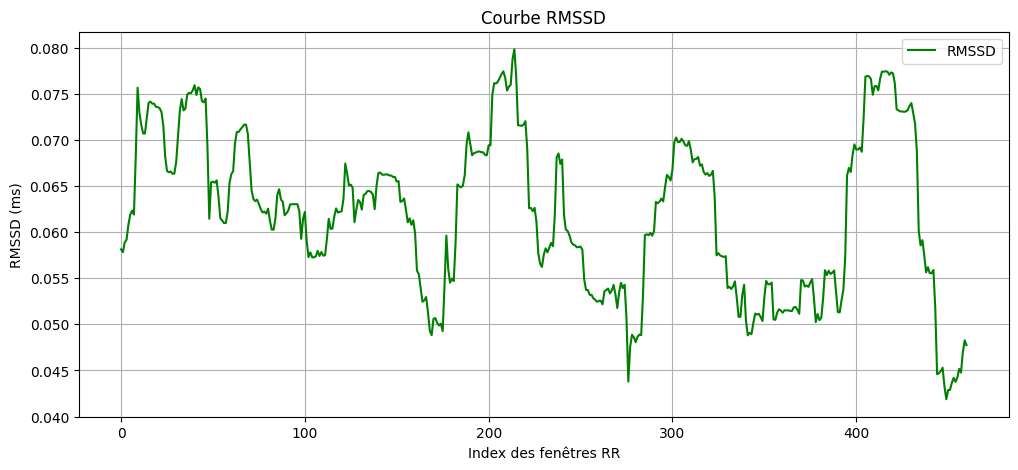

In [ ]:

# Fonction pour appliquer un filtre passe-bande
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Fonction pour filtrer le signal ECG
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

def detect_r_peaks(file_path, tolerance=0.2, threshold_ratio=0.04, time_limit=282, window_size=40, lowcut=0.5, highcut=95, fs=1000):
    # Charger et prétraiter les données
    df_full = pd.read_csv(file_path)
    df_full["time_sec"] = df_full["secs"] + df_full["nsecs"] / 1e9
    df_full["time_sec"] -= df_full["time_sec"].iloc[0]  # Décaler l'origine du temps

    # Filtrer pour afficher les données jusqu'à time_limit secondes
    df_5s = df_full[df_full["time_sec"] <= time_limit]

    # Appliquer un filtrage passe-bande pour nettoyer le signal ECG
    ecg_signal_filtered = bandpass_filter(df_5s["value"], lowcut, highcut, fs)

    # Détection des pics R sur le signal ECG filtré
    peaks, _ = find_peaks(ecg_signal_filtered, height=np.max(ecg_signal_filtered) * threshold_ratio)

    # Regrouper les pics proches
    grouped_peaks = group_close_peaks(peaks, df_5s["time_sec"], tolerance)

    # Conserver le pic maximal de chaque groupe
    final_peaks = [max(group, key=lambda x: df_5s["value"].iloc[x]) for group in grouped_peaks]

    # Calculer les intervalles RR
    rr_intervals = np.diff([df_5s["time_sec"].iloc[peak] for peak in final_peaks])

    # Calculer RMSSD pour chaque fenêtre glissante
    rmssd_values = calculate_rmssd_glissant(rr_intervals, window_size)

    # Tracer le signal ECG et RMSSD
    plot_ecg_with_rmssd(df_5s, ecg_signal_filtered, final_peaks, rmssd_values)

def group_close_peaks(peaks, time_sec, tolerance):
    grouped_peaks = []
    for peak in peaks:
        added = False
        for group in grouped_peaks:
            # Regrouper les pics proches en fonction de la tolérance
            if abs(time_sec.iloc[peak] - time_sec.iloc[group[-1]]) < tolerance:
                group.append(peak)
                added = True
                break
        if not added:
            grouped_peaks.append([peak])
    return grouped_peaks

def calculate_rmssd_glissant(rr_intervals, window_size):
    """Calculer le RMSSD glissant à partir des intervalles RR."""
    rmssd_values = []
    for i in range(len(rr_intervals) - window_size):
        rr_window = rr_intervals[i:i + window_size]
        rr_diff = np.diff(rr_window)
        rmssd = np.sqrt(np.mean(rr_diff**2))
        rmssd_values.append(rmssd)
    return rmssd_values

def plot_ecg_with_rmssd(df_5s, ecg_signal_filtered, final_peaks, rmssd_values):
    """Tracer le signal ECG avec les pics R détectés et le RMSSD."""
    plt.figure(figsize=(12, 5))

    # Tracer le signal ECG filtré
    plt.plot(df_5s["time_sec"], ecg_signal_filtered, label="Signal ECG Filtré", color="b")

    # Ajouter des lignes verticales pour les pics R
    for peak in final_peaks:
        plt.axvline(x=df_5s["time_sec"].iloc[peak], color='r', linestyle='--', alpha=0.75)

    # Ajouter le RMSSD sur un graphique séparé
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(rmssd_values)), rmssd_values, label="RMSSD", color="g")
    plt.xlabel("Index des fenêtres RR")
    plt.ylabel("RMSSD (ms)")
    plt.title("Courbe RMSSD")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel de la fonction avec votre fichier
detect_r_peaks(file_path1)


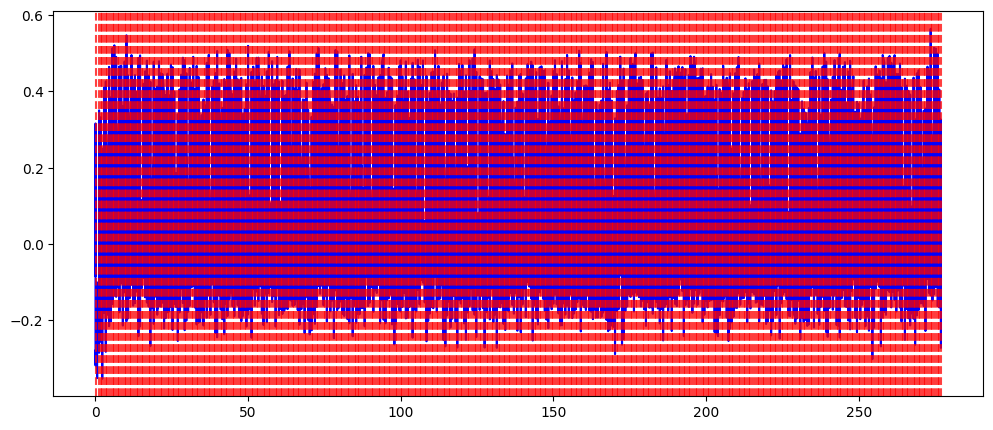

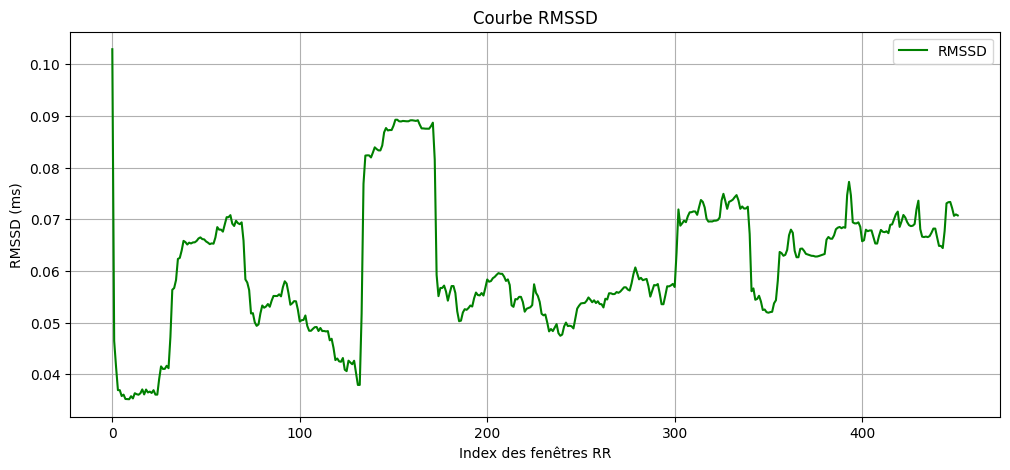

In [ ]:
detect_r_peaks(file_path2)

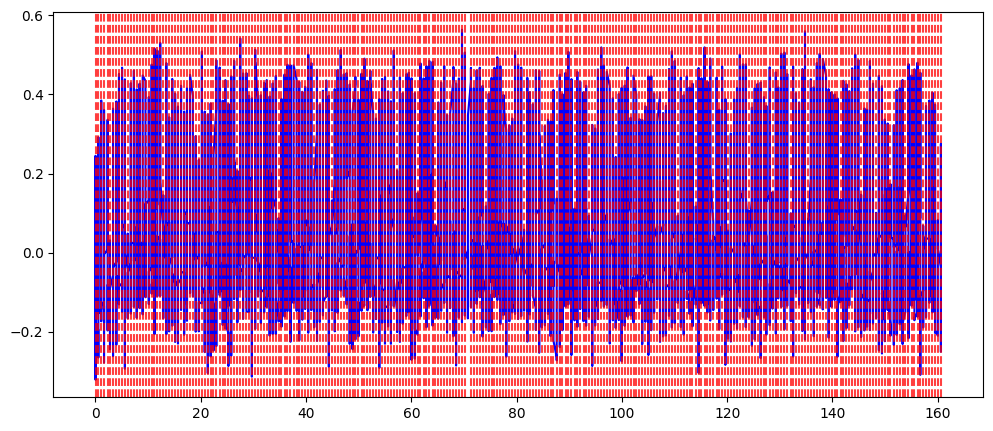

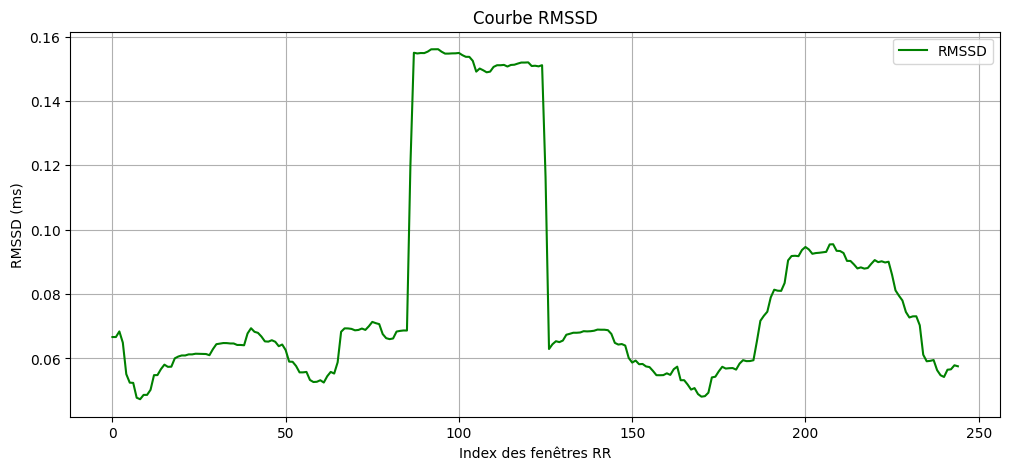

In [ ]:
detect_r_peaks(file_path3)

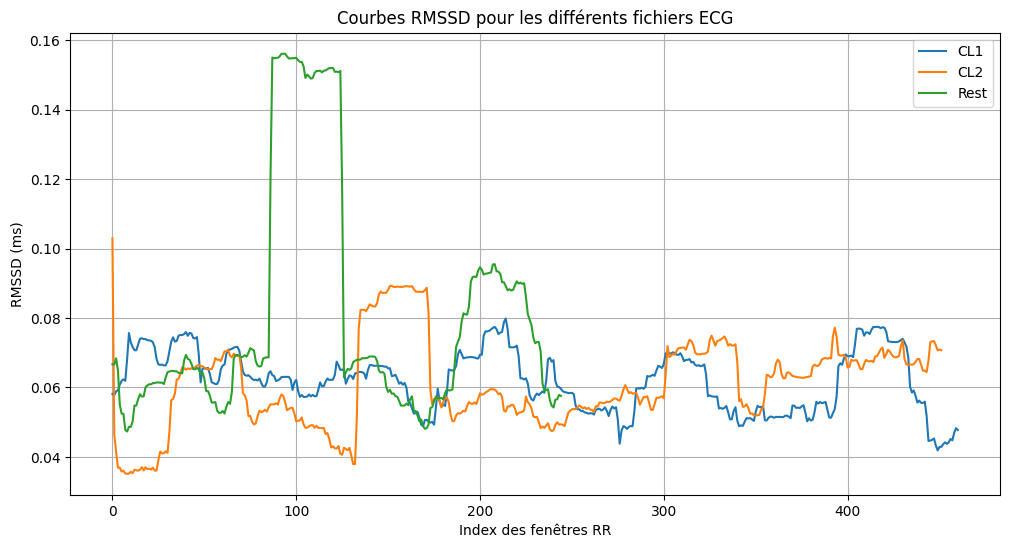

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# Fonction pour appliquer un filtre passe-bande
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Fonction pour filtrer le signal ECG
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

def detect_r_peaks(file_path, tolerance=0.2, threshold_ratio=0.04, time_limit=282, window_size=40, lowcut=0.5, highcut=95, fs=1000):
    # Charger et prétraiter les données
    df_full = pd.read_csv(file_path)
    df_full["time_sec"] = df_full["secs"] + df_full["nsecs"] / 1e9
    df_full["time_sec"] -= df_full["time_sec"].iloc[0]  # Décaler l'origine du temps

    # Filtrer pour afficher les données jusqu'à time_limit secondes
    df_5s = df_full[df_full["time_sec"] <= time_limit]

    # Appliquer un filtrage passe-bande pour nettoyer le signal ECG
    ecg_signal_filtered = bandpass_filter(df_5s["value"], lowcut, highcut, fs)

    # Détection des pics R sur le signal ECG filtré
    peaks, _ = find_peaks(ecg_signal_filtered, height=np.max(ecg_signal_filtered) * threshold_ratio)

    # Regrouper les pics proches
    grouped_peaks = group_close_peaks(peaks, df_5s["time_sec"], tolerance)

    # Conserver le pic maximal de chaque groupe
    final_peaks = [max(group, key=lambda x: df_5s["value"].iloc[x]) for group in grouped_peaks]

    # Calculer les intervalles RR
    rr_intervals = np.diff([df_5s["time_sec"].iloc[peak] for peak in final_peaks])

    # Calculer RMSSD pour chaque fenêtre glissante
    rmssd_values = calculate_rmssd_glissant(rr_intervals, window_size)

    return rmssd_values  # Retourner les valeurs RMSSD pour tracé ultérieur

def group_close_peaks(peaks, time_sec, tolerance):
    grouped_peaks = []
    for peak in peaks:
        added = False
        for group in grouped_peaks:
            # Regrouper les pics proches en fonction de la tolérance
            if abs(time_sec.iloc[peak] - time_sec.iloc[group[-1]]) < tolerance:
                group.append(peak)
                added = True
                break
        if not added:
            grouped_peaks.append([peak])
    return grouped_peaks

def calculate_rmssd_glissant(rr_intervals, window_size):
    """Calculer le RMSSD glissant à partir des intervalles RR."""
    rmssd_values = []
    for i in range(len(rr_intervals) - window_size):
        rr_window = rr_intervals[i:i + window_size]
        rr_diff = np.diff(rr_window)
        rmssd = np.sqrt(np.mean(rr_diff**2))
        rmssd_values.append(rmssd)
    return rmssd_values

def plot_rmssd_multiple(file_paths, labels):
    """Tracer les courbes RMSSD de plusieurs fichiers avec des labels personnalisés."""
    plt.figure(figsize=(12, 6))
    for file_path, label in zip(file_paths, labels):
        rmssd_values = detect_r_peaks(file_path)  # Obtenez les valeurs RMSSD pour chaque fichier
        plt.plot(np.arange(len(rmssd_values)), rmssd_values, label=label)  # Utiliser le label personnalisé

    plt.xlabel("Index des fenêtres RR")
    plt.ylabel("RMSSD (ms)")
    plt.title("Courbes RMSSD pour les différents fichiers ECG")
    plt.legend()
    plt.grid()
    plt.show()


labels = ['CL1', 'CL2', 'Rest'] # Les Conditions

plot_rmssd_multiple([file_path1, file_path2, file_path3], labels)


# **Analyse de la variabilité de la fréquence cardiaque (HRV) à partir des intervalles RR**
Dans cette section, on extraire et analyse les intervalles RR du signal ECG pour évaluer la variabilité de la fréquence cardiaque (HRV). L'objectif est de calculer le ratio HF/LF

Les principales étapes sont :

-Filtrage du signal ECG : Utilisation d'un filtre passe-bande pour éliminer le bruit.

-Détection des pics R : Identification des maxima du signal ECG correspondant aux complexes QRS.

-Calcul des intervalles RR : Mesure des variations temporelles entre les pics R successifs.

-Analyse spectrale : Application de la méthode Welch pour estimer la densité spectrale de puissance (PSD).

-Calcul des puissances LF et HF : Intégration des plages de fréquences LF (0.04-0.15 Hz) et HF (0.15-0.4 Hz).

-Détermination du ratio HF/LF : Évaluation de l'équilibre entre les systèmes sympathique et parasympathique.

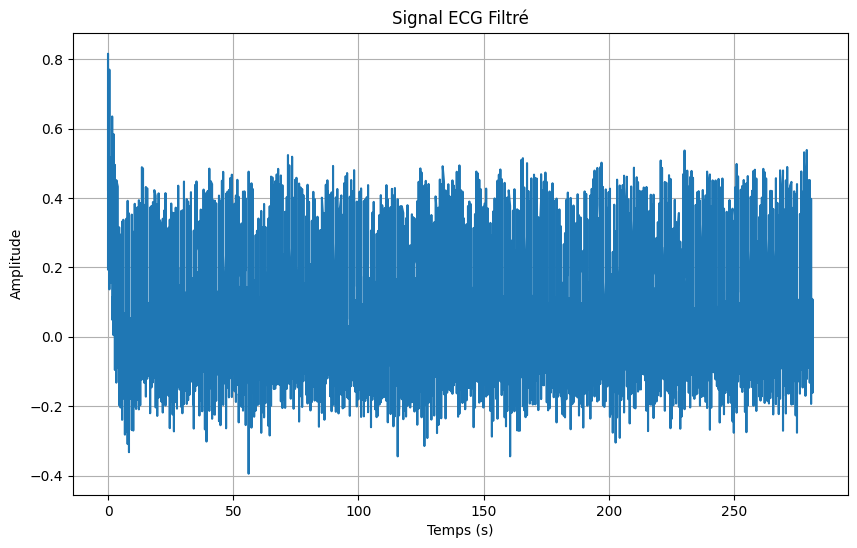

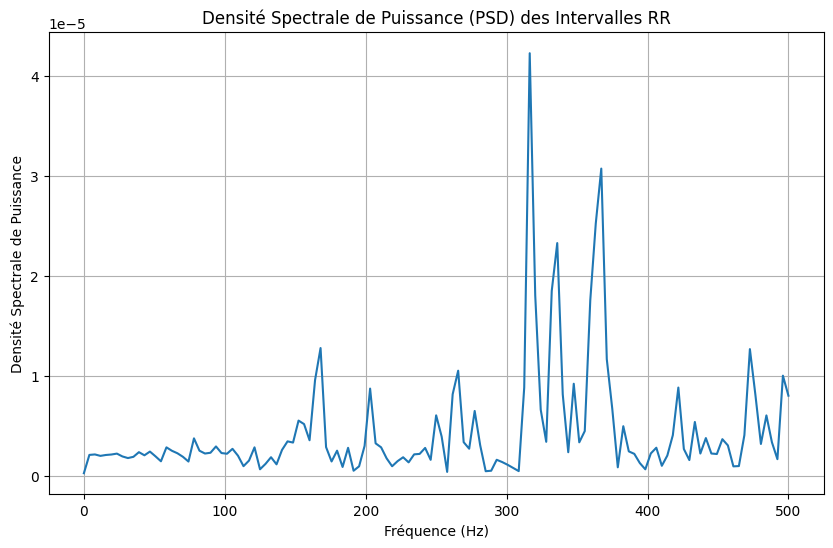

Ratio HF/LF : 6.580201200845562


In [ ]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import pandas as pd
from scipy.signal import welch

# Fonction de filtrage passe-bande
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Fonction pour regrouper les pics proches
def group_close_peaks(peaks, time, tolerance):
    groups = []
    current_group = [peaks[0]]

    for i in range(1, len(peaks)):
        if time[peaks[i]] - time[peaks[i-1]] <= tolerance:
            current_group.append(peaks[i])
        else:
            groups.append(current_group)
            current_group = [peaks[i]]

    groups.append(current_group)
    return groups

# Fonction principale pour détecter les intervalles RR
def detect_rr_intervals(file_path, tolerance=0.2, threshold_ratio=0.04, time_limit=282, lowcut=0.5, highcut=95, fs=1000):
    # Charger et prétraiter les données
    df_full = pd.read_csv(file_path)
    df_full["time_sec"] = df_full["secs"] + df_full["nsecs"] / 1e9
    df_full["time_sec"] -= df_full["time_sec"].iloc[0]  # Décaler l'origine du temps

    # Filtrer pour afficher les données jusqu'à time_limit secondes
    df_5s = df_full[df_full["time_sec"] <= time_limit]

    # Appliquer un filtrage passe-bande pour nettoyer le signal ECG
    ecg_signal_filtered = bandpass_filter(df_5s["value"], lowcut, highcut, fs)

    # Tracer le signal ECG filtré
    plt.figure(figsize=(10, 6))
    plt.plot(df_5s["time_sec"], ecg_signal_filtered, label="Signal ECG filtré")
    plt.title('Signal ECG Filtré')
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Détection des pics R sur le signal ECG filtré
    peaks, _ = find_peaks(ecg_signal_filtered, height=np.max(ecg_signal_filtered) * threshold_ratio)

    # Regrouper les pics proches
    grouped_peaks = group_close_peaks(peaks, df_5s["time_sec"], tolerance)

    # Conserver le pic maximal de chaque groupe
    final_peaks = [max(group, key=lambda x: df_5s["value"].iloc[x]) for group in grouped_peaks]

    # Calculer les intervalles RR
    rr_intervals = np.diff([df_5s["time_sec"].iloc[peak] for peak in final_peaks])
    return rr_intervals

rr_intervals = detect_rr_intervals(file_path1)
# Calculer la densité spectrale de puissance (PSD) des intervalles RR en utilisant scipy.signal.welch
frequencies, psd = welch(rr_intervals, fs=1000, nperseg=256)

# Afficher le spectre de puissance
plt.figure(figsize=(10, 6))
plt.plot(frequencies, psd)
plt.title('Densité Spectrale de Puissance (PSD) des Intervalles RR')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité Spectrale de Puissance')
plt.grid(True)
plt.show()

# Plages de fréquences LF (0.04-0.15 Hz) et HF (0.15-0.4 Hz)
lf_band = (frequencies >= 0.04 * 1000) & (frequencies <= 0.15* 1000)
hf_band = (frequencies >= 0.15* 1000) & (frequencies <= 0.4* 1000)

# Calcul de la puissance dans chaque bande
power_LF = np.trapz(psd[lf_band], frequencies[lf_band])
power_HF = np.trapz(psd[hf_band], frequencies[hf_band])

# Calcul du ratio HF/LF
if power_LF == 0 or power_HF == 0:
    ratio_hf_lf = 0
else:
    ratio_hf_lf = power_HF / power_LF

print(f"Ratio HF/LF : {ratio_hf_lf}")


Ratio HF/LF pour Rest: 4.5544
Ratio HF/LF pour 1-back: 6.5802
Ratio HF/LF pour 2-back: 44.5372


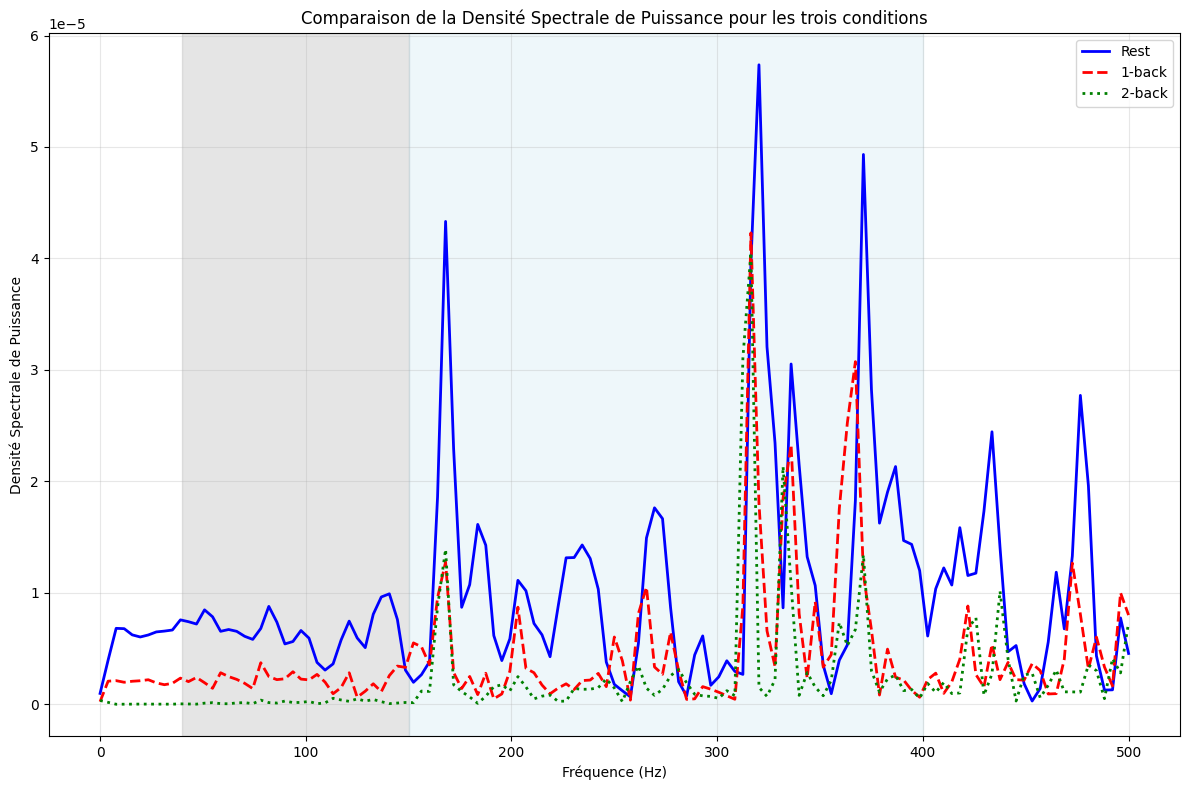

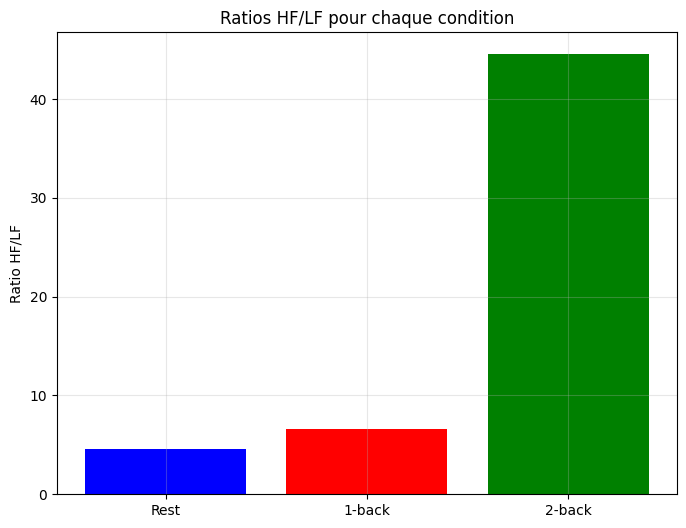

In [ ]:
# Fonction de filtrage passe-bande
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Fonction pour regrouper les pics proches
def group_close_peaks(peaks, time, tolerance):
    groups = []
    current_group = [peaks[0]]
    for i in range(1, len(peaks)):
        if time[peaks[i]] - time[peaks[i-1]] <= tolerance:
            current_group.append(peaks[i])
        else:
            groups.append(current_group)
            current_group = [peaks[i]]
    groups.append(current_group)
    return groups

# Fonction principale pour détecter les intervalles RR
def detect_rr_intervals(file_path, tolerance=0.2, threshold_ratio=0.04, time_limit=282, lowcut=0.5, highcut=95, fs=1000):
    # Charger et prétraiter les données
    df_full = pd.read_csv(file_path)
    df_full["time_sec"] = df_full["secs"] + df_full["nsecs"] / 1e9
    df_full["time_sec"] -= df_full["time_sec"].iloc[0]

    # Filtrer pour afficher les données jusqu'à time_limit secondes
    df_5s = df_full[df_full["time_sec"] <= time_limit]

    # Appliquer un filtrage passe-bande pour nettoyer le signal ECG
    ecg_signal_filtered = bandpass_filter(df_5s["value"], lowcut, highcut, fs)

    # Détection des pics R sur le signal ECG filtré
    peaks, _ = find_peaks(ecg_signal_filtered, height=np.max(ecg_signal_filtered) * threshold_ratio)

    # Regrouper les pics proches
    grouped_peaks = group_close_peaks(peaks, df_5s["time_sec"], tolerance)

    # Conserver le pic maximal de chaque groupe
    final_peaks = [max(group, key=lambda x: df_5s["value"].iloc[x]) for group in grouped_peaks]

    # Calculer les intervalles RR
    rr_intervals = np.diff([df_5s["time_sec"].iloc[peak] for peak in final_peaks])
    return rr_intervals

# Configuration des conditions
conditions = {
    'Rest': {'file': file_path3, 'color': 'blue', 'linestyle': '-'},
    '1-back': {'file': file_path1, 'color': 'red', 'linestyle': '--'},
    '2-back': {'file': file_path2, 'color': 'green', 'linestyle': ':'}
}

# Créer une figure pour le graphique combiné
plt.figure(figsize=(12, 8))

# Dictionnaire pour stocker les ratios HF/LF
ratios = {}

# Analyser chaque condition
for condition_name, config in conditions.items():
    rr_intervals = detect_rr_intervals(config['file'])

    # Calculer la densité spectrale de puissance (PSD)
    frequencies, psd = welch(rr_intervals, fs=1000, nperseg=256)

    # Tracer la PSD avec le style spécifié pour chaque condition
    plt.plot(frequencies, psd,
             color=config['color'],
             linestyle=config['linestyle'],
             label=f'{condition_name}',
             linewidth=2)

    # Calculer les bandes de fréquence
    lf_band = (frequencies >= 0.04 * 1000) & (frequencies <= 0.15 * 1000)
    hf_band = (frequencies >= 0.15 * 1000) & (frequencies <= 0.4 * 1000)

    # Calculer les puissances
    power_LF = np.trapz(psd[lf_band], frequencies[lf_band])
    power_HF = np.trapz(psd[hf_band], frequencies[hf_band])

    # Calculer et stocker le ratio HF/LF
    ratio = power_HF / power_LF if power_LF != 0 and power_HF != 0 else 0
    ratios[condition_name] = ratio
    print(f"Ratio HF/LF pour {condition_name}: {ratio:.4f}")

# Personnaliser le graphique
plt.title('Comparaison de la Densité Spectrale de Puissance pour les trois conditions', fontsize=12)
plt.xlabel('Fréquence (Hz)', fontsize=10)
plt.ylabel('Densité Spectrale de Puissance', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Ajouter une zone colorée pour les bandes LF et HF
plt.axvspan(0.04 * 1000, 0.15 * 1000, color='gray', alpha=0.2, label='Bande LF')
plt.axvspan(0.15 * 1000, 0.4 * 1000, color='lightblue', alpha=0.2, label='Bande HF')

# Ajuster la mise en page
plt.tight_layout()

# Créer un deuxième graphique pour les ratios HF/LF
plt.figure(figsize=(8, 6))
conditions_names = list(ratios.keys())
ratio_values = list(ratios.values())

plt.bar(conditions_names, ratio_values, color=['blue', 'red', 'green'])
plt.title('Ratios HF/LF pour chaque condition')
plt.ylabel('Ratio HF/LF')
plt.grid(True, alpha=0.3)

# Afficher les graphiques
plt.show()